# Welcome to the Final Project!

Course: https://courses.thinkautonomous.ai/obstacle-tracking

In this project, you will learn to associate bounding boxes on multiple frames using the Hungarian Algorithm!


You will work on 3 aspects of the **multi-object tracker**:

*   Use YOLO and launch an object detection algorithm
*   Use The Hungarian Algorithm and associate the boxes
*   Improve the algorithm to avoid false positives and false negatives


This is a part included to link your Google Colab file (.ipynb) to your Google Drive folder.

If you don't work on Colab, you won't need these.

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

os.chdir("/content/drive/My Drive/SDC Course/Tracking")
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
association_hungarian.ipynb	     Images	       yolo_for_tracking.py
association_hungarian_Starter.ipynb  Output	       yolo.ipynb
final_project.ipynb		     __pycache__       yolo_Starter.ipynb
final_project_Starter.ipynb	     Tracking.gslides  Yolov3


# 1 - Detection

In order to make multi-object tracking work, we will need to do a detection step. The tracking will heavily rely on the detector, it better be good.

We will choose the [YOLO algorithm](https://pjreddie.com/darknet/yolo/) that is both accurate and fast.

<img src="https://miro.medium.com/max/1446/1*YpNE9OQeshABhBgjyEXlLA.png" width="500">


Eventually, we want bounding box detection

<img src="https://pjreddie.com/media/image/Screen_Shot_2018-03-24_at_10.48.42_PM.png" width="500">


## Import Libraries and Test Images

Let's import the libraries and test images.<p>
I took a video and wrote a short script to take a picture every 7 frame of the image. Instead of working at **60 FPS** (recording frame rate), consider you have an algorithm working at 60/7 or about **9 frame per second**.<p>_

**Why the cut ?**<p>
YOLO is very fast, it can work at 60 FPS.
For tracking to be a bit challenging, let's not have 99% IOU every time.

In [ ]:
### Imports
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import copy
import pickle
import cv2

In [ ]:
### Load the Images
dataset_images = pickle.load(open('Images/images_tracking.p', "rb"))

In [ ]:
def visualize_images(input_images):
    fig=plt.figure(figsize=(100,100))

    for i in range(len(input_images)):
        fig.add_subplot(1, len(input_images), i+1)
        plt.imshow(input_images[i])
    plt.show()

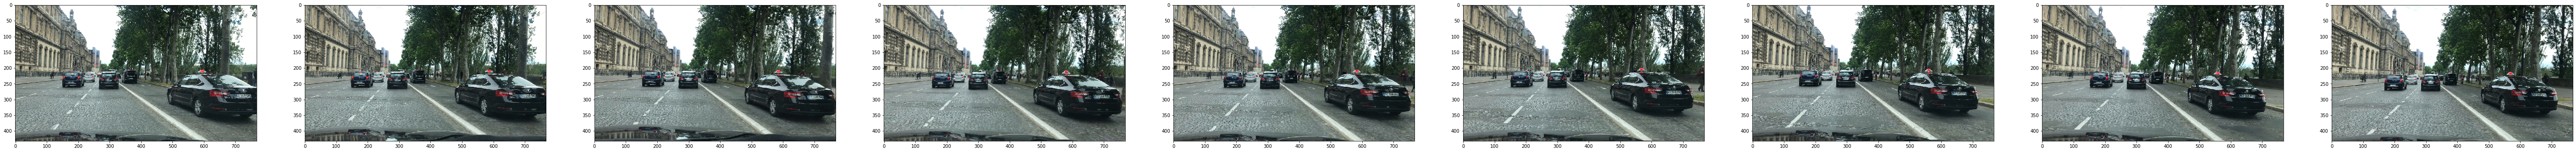

In [ ]:
visualize_images(dataset_images)

## Run Initial Obstacle Detection - Modify the YOLO file

We will need to modify the original yolo.py file. Go to this file, **duplicate it**, and **modify the duplicate online** using Google Drive's text editor. <p>_

**What modifications should you do?**<p>
The current *inference()* function outputs an image.
To work with the hungarian algorithm, we will need the bounding box.<p>
* **Modify the postprocess()** function as well as the **inference() function** to **return the bounding box**.
* Then, we will only work with the original image and the bounding boxes
* Call the new file **yolo_modified.py**
 and import it

In [ ]:
### Run obstacle detection for the images
from yolo_for_tracking import *

## RUN OBSTACLE DETECTION ON EACH IMAGE; STORE THE RESULTS IN A LIST OF IMAGES, AND A LIST OF BOXES
## YOUR CODE HERE


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Print the results and the detected boxes

## YOUR CODE HERE

## One Obstacle - One Color
**Last Step!** <p>
We now one one color per bounding box! All cars in blue is useless! <p>
We will create an Obstacle class that we will modify.
Each detected obstacle should have:
* an id
* a current bounding box
* a previous bounding box<p>_

**In the end, we will draw a bounding box based on the id.** <p>
If the id changes, the color will change also.

In [ ]:
class Obstacle():
    def __init__(self, idx, box):
        """
        Init function. The obstacle must have an id and a box.
        """
        self.idx = idx
        self.box = box

In [ ]:
def id_to_color(idx):
    """
    Random function to convert an id to a color
    Do what you want here but keep numbers below 255
    """
    blue = idx*5 % 256
    green = idx*36 %256
    red = idx*23 %256
    return (red, green, blue)

In [ ]:
def main():
    """
    Main function.
    You already ran the detector on all 9 images. The variable is result_boxes.
    Use this to assign an id and draw a rectangle based on the id.
    """
    ## YOUR CODE HERE
    pass

result_images_2 = main()

In [ ]:
## Print the results
visualize_images(result_images_2)

We did it!<p>...<p>

But as you can see, the colors are not kept along the images. **We don't have active tracking yet**!

# 2 - Association

We now have a detection algorithm working! Congratulations!
The next step is to **match the detections** from one frame to another and **keep the color along the 9 images**.<p>
It should be dynamic and **work no matter the number of images**. In the end, we'll apply **this algorithm on a video**.

Eventually, we'll want a good association system

![Texte alternatif…](https://miro.medium.com/proxy/0*yN9MllhmuglJORss.png)

## Metrics

The first thing we'll need is to define a metric!

* If you **don't want a big challenge**, the **IOU cost** will do just fine!
* If you want a **medium challenge**, you can try to **implement [this paper](https://arxiv.org/pdf/1709.03572.pdf)**. Read carefully page 19-20 and try to implement these costs with IOU. It will filter out incoherent boxes.
* If you want the **biggest challenge**, try to **code [Deep SORT](https://arxiv.org/pdf/1703.07402.pdf)** and associate Deep Convolutional features to it. <p>

In the end, you should have a **single number in the cost matrix**. And it should be representative of the cost, like IOU is.

### IOU COST

In [ ]:
def convert_data(box):
    """
    Convert data from (x1,y1, w, h) to (x1,y1,x2,y2)
    """
    x1 = box[0]
    x2 = box[0] + box[2]
    y1 = box[1]
    y2 = box[1]+box[3]
    return x1,y1,x2,y2

def box_iou(box1, box2):
    """
    Computer Intersection Over Union cost
    """
    box1 = convert_data(box1)
    box2 = convert_data(box2)
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    inter_area = max(0, xB - xA + 1) * max(0, yB - yA + 1) #abs((xi2 - xi1)*(yi2 - yi1))
    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1) #abs((box1[3] - box1[1])*(box1[2]- box1[0]))
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1) #abs((box2[3] - box2[1])*(box2[2]- box2[0]))
    union_area = (box1_area + box2_area) - inter_area
    # compute the IoU
    iou = inter_area/float(union_area)
    return iou

### Exponential, Linear, And IOU Costs

Use this paper to code the solution: https://arxiv.org/pdf/1709.03572.pdf

In [ ]:
## CREATE A FUNCTION HUNGARIAN_COST THAT OUTPUTS THE HUNGARIAN COST AS IN THE PAPER
## BE CAREFUL NOT TO DIVIDE BY ZERO

## YOUR CODE HERE
def hungarian_cost():
    pass

## The Hungarian Algorithm
We can now use the previous code from the workshop to track bounding boxes!

* Create an **associate()** function that takes **two lists of boxes** (time t-1 and time t) and that outputs **the matches, the new detections, and the unmatched tracks**.

In [ ]:
from scipy.optimize import linear_sum_assignment

def associate(old_boxes, new_boxes):
    """
    old_boxes will represent the former bounding boxes (at time 0)
    new_boxes will represent the new bounding boxes (at time 1)
    Function goal: Define a Hungarian Matrix with IOU as a metric and return, for each box, an id
    RETURN: Matches, Unmatched Detections, Unmatched Trackers
    """
    ## YOUR CODE HERE
    pass

## Main Loop

In [ ]:
def main(input_image):
    """
    Receives an images
    Outputs the result image, and a list of obstacle objects 
    """
    ## YOUR CODE HERE
    pass

In [ ]:
### Call the main loop

yolo = YOLO()
idx = 0

fig=plt.figure(figsize=(100,100))

result_images_3 = copy.deepcopy(dataset_images)

out_imgs = []

for i in range(len(result_images_3)):
    out_img, stored_obstacles = main(result_images_3[i])
    out_imgs.append(out_img)
    fig.add_subplot(1, len(result_images_3), i+1)
    plt.imshow(out_imgs[i])

plt.show()

# 3 - Improvement

### Changing the Non Maxima Suppression formula

In OpenCV DNN, NMS (Non Maxima Suppression) is computer per class, insteaf of on the whole list. For that reason, we may arrive at unwanted results:
![](https://user-images.githubusercontent.com/25801568/79720833-01a88180-82ea-11ea-993b-8accd6b7fcc1.png)

I have found a new Non-Maxima Suppression formula we can use [on PyImageSearch's page](https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/).

We have to adapt it:

*   We have (x1,y1,w,h) and we the function takes (x1,y1, x2, y2)
*   That's it!



In [ ]:
from yolo_nms import *

yolo = YOLO()
idx = 0

fig=plt.figure(figsize=(100,100))

result_images_3 = copy.deepcopy(dataset_images)

out_imgs = []

for i in range(len(result_images_3)):
    out_img, stored_obstacles = main(result_images_3[i])
    out_imgs.append(out_img)
    fig.add_subplot(1, len(result_images_3), i+1)
    plt.imshow(out_imgs[i])

## TODO: Run this and compare the results!

### Using Age

We now have a pretty good tracker! <p>
One thing that is not very good is that it relies solely on the detector.
If we miss the detection, we miss everything. <p>

In this part, we'll introduce two ideas:
* False Positive
* False Negative<p>

A **false positive** means that you detected an obstacle that shouldn't detect.<p>
We'll solve it by introducing a **MIN_HIT_STREAK** variable. If the detector detects something once, it is not displayed. If it **detects it twice in a row**, or 3 times in a row (thanks to matching), it is displayed.

A **false negative** means that you didn't detect an obstacle that should have been detected.<p>
We'll solve it by introducing a **MAX_AGE** variable. If an obstacle is suddently unmatched, we **keep displaying** it. If it is unmatched again, or more times, we remove it.

In [ ]:
MIN_HIT_STREAK = ## YOUR CODE HERE
MAX_UNMATCHED_AGE = ## YOUR CODE HERE

**Obstacle Class** <p>
Let's redefine the Obstacle class to include these values
Every obstacle should have:
* an id
* a box
* an age (number of times matched)
* an unmatched frame number (number of times unmatched)

In [ ]:
class Obstacle():
    def __init__(self, idx, box, age=1, unmatched_age=0):
        self.idx = idx
        self.box = box
        ## ADD AGE AND UNMATCHED AGE
        ## YOUR CODE HERE

**Main Loop**<p>
Now we can redefine the main loop
We simply add conditions to display or not an obstacle

In [ ]:
def main(input_image):
    """
    Receives an images
    Outputs the result image, and a list of obstacle objects 
    """
    ## MODIFY THE MAIN FUNCTION TO NOW CONSIDER AGE AND UNMATCHED AGE
    pass

In [ ]:
yolo = YOLO()
idx = 0

fig=plt.figure(figsize=(100,100))

result_images_3 = copy.deepcopy(dataset_images)

out_imgs = []

for i in range(len(result_images_3)):
    out_img = main(result_images_3[i])
    out_imgs.append(out_img)
    fig.add_subplot(1, len(result_images_3), i+1)
    plt.imshow(out_imgs[i])

plt.show()

# Video

Now is the time to run on a video. Import the video_0 file and run it in Paris!
If you have GPU, it's even better.
Otherwise, use a subclip function to run it only on the first seconds

In [ ]:
from moviepy.editor import VideoFileClip
idx = 0
detector = YOLO()
#video_file = "/content/drive/My Drive/Think Autonomous/SDC Course/Tracking/Images/video_0.MOV"
#video_file = "/content/drive/My Drive/Think Autonomous/SDC Course/Tracking/Images/MOT16-13-raw.mp4" #25 FPS
video_file = "/content/drive/My Drive/Think Autonomous/SDC Course/Tracking/Images/MOT16-14-raw.mp4" #25 FPS
clip = VideoFileClip(video_file).subclip(0,5)
white_clip = clip.fl_image(main)
%time white_clip.write_videofile("/content/drive/My Drive/Think Autonomous/SDC Course/Tracking/Output/movie_track_kf_out.mp4",audio=False)